In [2]:
# notebook used for saving plots

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pickle
from sklearn.manifold import TSNE
import os
import glob
from pathlib import Path
from keras.models import load_model
from tensorflow.keras import models
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import pandas as pd


# directory to save plots to
save_dir = r"C:\Users\arpan\OneDrive\Documents\GRB\Plots"

# Accessing the default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def save_to_dir(fig, filename, directory = save_dir, format='pdf', dpi=400, create_dir=False, **kwargs):
    """
    Save a matplotlib figure to a specified directory with error handling.
    
    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        The figure to save
    directory : str
        Directory path where the figure should be saved
    filename : str
        Name of the file (without extension)
    format : str, optional
        File format (e.g., 'png', 'pdf', 'svg', 'jpg')
        Default is 'png'
    dpi : int, optional
        Resolution in dots per inch
        Default is 400
    create_dir : bool, optional
        Whether to create the directory if it doesn't exist
        Default is False
    **kwargs : dict
        Additional arguments passed to plt.savefig()
    
    Returns:
    --------
    str
        Path to the saved file if successful, None if failed
    """
    try:
        # Convert directory to Path object
        dir_path = Path(directory)
        
        # Create directory if it doesn't exist and create_dir is True
        if not dir_path.exists():
            if create_dir:
                dir_path.mkdir(parents=True, exist_ok=True)
            else:
                raise FileNotFoundError(f"Directory {directory} does not exist")
        
        # Ensure filename has the correct extension
        if not filename.endswith(f'.{format}'):
            filename = f'{filename}.{format}'
        
        # Create full file path
        file_path = dir_path / filename
        
        # Save the figure
        fig.savefig(
            file_path,
            format=format,
            dpi=dpi,
            bbox_inches='tight',
            **kwargs
        )
        
        print(f"Figure saved successfully to: {file_path}")
        return str(file_path)
        
    except Exception as e:
        print(f"Error saving figure: {str(e)}")
        return None

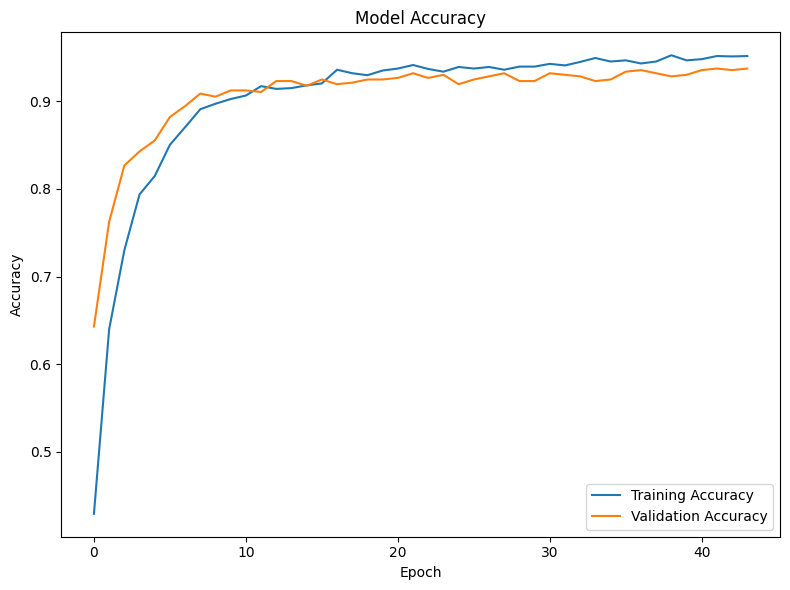

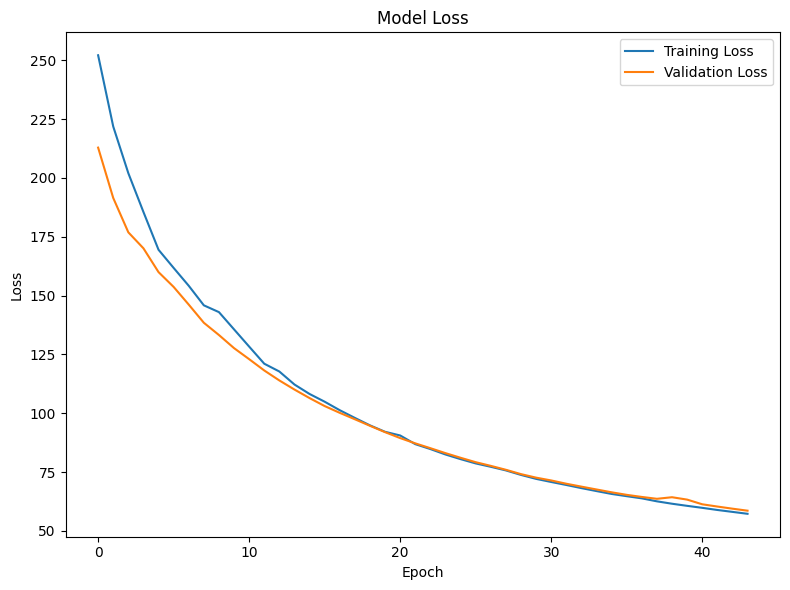

Figure saved successfully to: C:\Users\arpan\OneDrive\Documents\GRB\Plots\accuracy_curve_midcl.pdf
Figure saved successfully to: C:\Users\arpan\OneDrive\Documents\GRB\Plots\loss_curve_midcl.pdf


'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\Plots\\loss_curve_midcl.pdf'

In [39]:
# learning curves
history_path = r"C:\Users\arpan\OneDrive\Documents\GRB\models\midcl5\trainHistoryDict" # the path to the history file

def plot_training_history(history_path):
    # Load the history file
    with open(history_path, 'rb') as file:
        history = pickle.load(file)

    size = (8,6)
    figA = plt.figure(figsize=size)
    
    # Plot training & validation accuracy
    if 'accuracy' in history:
        plt.plot(history['accuracy'], label='Training Accuracy')
        if 'val_accuracy' in history:
            plt.plot(history['val_accuracy'], label='Validation Accuracy')
    elif 'acc' in history:  # For older Keras versions
        plt.plot(history['acc'], label='Training Accuracy')
        if 'val_acc' in history:
            plt.plot(history['val_acc'], label='Validation Accuracy')
            
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    
    figL = plt.figure(figsize=size)

    # Plot training & validation loss
    plt.plot(history['loss'], label='Training Loss')
    if 'val_loss' in history:
        plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

    # # Print final values
    # print("\nFinal Training Metrics:")
    # for metric in history.keys():
    #     print(f"{metric}: {history[metric][-1]:.4f}")

    return figA, figL

fig1, fig2 = plot_training_history(history_path)
save_to_dir(fig1, 'accuracy_curve_midcl') # change names for clarity
save_to_dir(fig2, 'loss_curve_midcl')     # change names for clarity

The path 'C:\Users\arpan\OneDrive\Documents\GRB\data\DCL_ds2new' exists.
{'bin list': [0.001, 0.004, 0.016, 0.064, 0.256, 1.024, 4.096], 'time interval': 'n/a', 'number of data points': 499, 'data set name': 'DCL_ds2', 'data set path': 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_ds2', 'channel ranges': [[3, 50], [51, 124]], 'ratio': 0.5, 'type': 'hrates', 'include unprocessed': False}
bin edges calculated correctly
6986
6986
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Yes


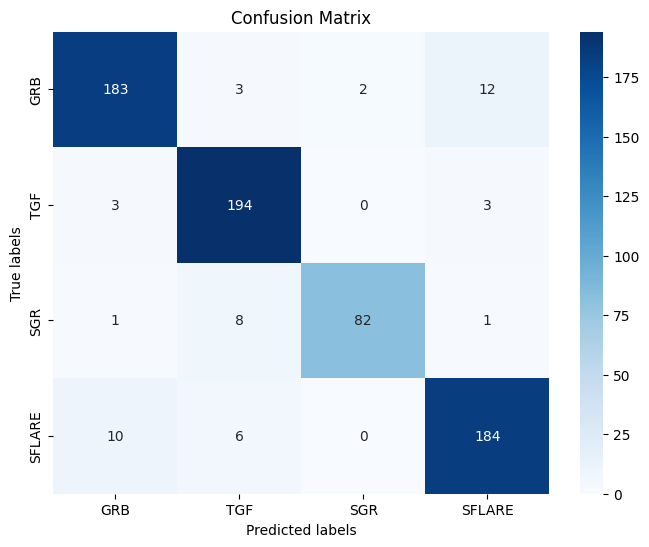

Figure saved successfully to: C:\Users\arpan\OneDrive\Documents\GRB\Plots\con_mat_4c_midcl.pdf


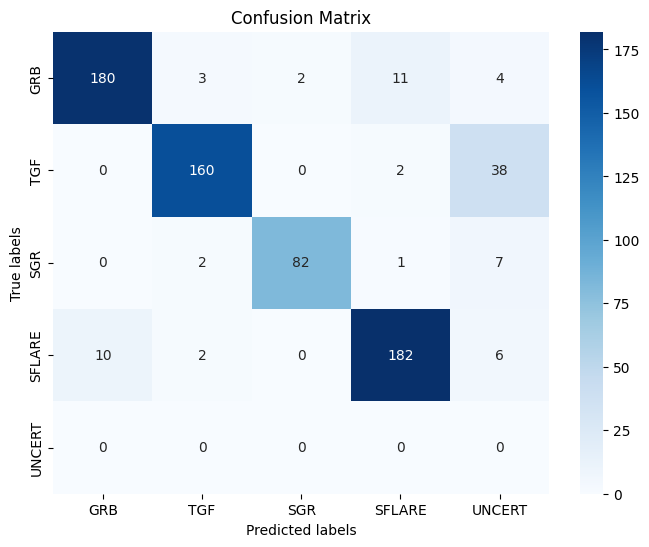

Figure saved successfully to: C:\Users\arpan\OneDrive\Documents\GRB\Plots\con_mat_5c_midcl.pdf


'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\Plots\\con_mat_5c_midcl.pdf'

In [40]:
# confusion matrices plus one with 5th class

dir_path = r"C:\Users\arpan\OneDrive\Documents\GRB\data\DCL_ds2new"  # path to the data set
model_path = r"C:\Users\arpan\OneDrive\Documents\GRB\models\midcl5\MI-DCL.keras" # path to the model

# Check if the path exists
if os.path.exists(dir_path):
    print(f"The path '{dir_path}' exists.")
else:
    print(f"The path '{dir_path}' does not exist.")


# importing data
event_types = {1:'GRB',2:'TGF',3:'SGR',4:'SFLARE'}

test_dir = os.path.join(dir_path,"test")  
train_dir = os.path.join(dir_path,"train")

# Replace 'your_search_string' with the string you are looking for in file names
search_string = 'bn'

search_pattern = os.path.join(test_dir, f'*{search_string}*')
test_files = glob.glob(search_pattern)

search_pattern = os.path.join(train_dir, f'*{search_string}*')
train_files = glob.glob(search_pattern)

def find_json_file(directory):
    for root, dirs, files in os.walk(directory):
        for file_name in files:
            if file_name.endswith('.json'):
                file_path = os.path.join(root, file_name)
                with open(file_path, 'r') as file:
                    try:
                        json_data = json.load(file)
                        return json_data
                    except json.JSONDecodeError:
                        print(f"Error: JSON decode failed for file '{file_path}'")
    print("No JSON file found in the directory.")
    return None

json_data = find_json_file(dir_path)
print(json_data)

# removing duplicate SGRs
train_files = [file for file in train_files if not file.endswith('d')]
test_files = [file for file in test_files if not file.endswith('d')]

dno = json_data['number of data points']

try:
    inup = json_data['include unprocessed']
except:
    inup = False
try:
    chrn = json_data['channel ranges']
except:
    chrn = 1
    
try:
    t = json_data['time interval'][1]-json_data['time interval'][0]
except:
    t='n/a'
    
# Calculating the number of points in each binnning
bin_list = json_data['bin list']
extra = 2 if inup else 1
dno_list = (len(bin_list)) * (len(chrn)*extra)  * [dno]
data_total = sum(dno_list)

fileno = 98
# Open the file in read mode
with open(train_files[fileno], 'r') as file:
    # Read all lines into a list
    lines = file.readlines()
# print('hello',train_files[fileno],len(lines))

check_data = np.loadtxt(train_files[fileno], delimiter=' ').astype(np.int32)
len_data = len(check_data)

# print(dno_list)
if data_total == len_data and len(dno_list) == (len(bin_list)) * (len(chrn)*extra):
    print('bin edges calculated correctly')
    print(data_total)
    print(len_data)
else:
    print('inconsistency in bin edges calculated and data')
    print(data_total)
    print(len_data)
    
# print('channel range no',chrn)
# print('number of data points',dno)
# print('time interval',t)



def process_file(file, X,Y,event_counter,inup = inup, dno_list = dno_list): # for MI-DCL
    """
    takes a file and processes it and adds it to the data set
    file:path to the file to be processed
    X:data set to be added to
    Y:list of labels of data
    dno_list:list of number of data points in each binning as calculated previously
    
    returns updated X and Y and event_counter
    """
    # fetching data from file and checking if label is considered
    event_type , event_name = file.split('\\')[-1].split('_') # changed here for difference in path structure
    loaded_data = np.loadtxt(file, delimiter='\t').astype(np.float32)
    if event_type not in event_counter.keys():
        return X,Y,event_counter
    
    y = [0,0,0,0]
    
    # setting and updating Y
    for key,value in event_types.items():
        if value in file.split('\\')[-1]:
            y[key-1] = 1
            Y.append(y)
            event_counter[value] += 1
            
    extra = 2 if inup else 1
    
    # setting and updating X
    f = 0
    for k,dno in zip(X.keys(),dno_list):
        datlist = []
        for i in range(len(chrn) * extra):
            datlist.append(loaded_data[f:f+dno])
            f = f + int(dno)
#         print(len(datlist))
        X[k].append(np.array(datlist).transpose())
        
    return X,Y,event_counter

# initializing train and test sets
X_train = {str(key): [] for key in bin_list}
Y_train = []
train_event_counter = {'GRB':0,'TGF':0,'SGR':0,'SFLARE':0}

X_test = {str(key): [] for key in bin_list}
Y_test = []
test_event_counter = {'GRB':0,'TGF':0,'SGR':0,'SFLARE':0}

# print(process_file(train_files[1],X_train,Y_train,train_event_counter,inup))

# processing train and test data sets for MI-DCL
for file in train_files[:]:
    X_train,Y_train,train_event_counter = process_file(file,X_train,Y_train,train_event_counter,inup = inup, dno_list = dno_list)
# print('training events\n',train_event_counter)
# print('total events : ', sum([i for i in train_event_counter.values()]))
Y_train = np.array(Y_train)
# print('shape of Y_train', Y_train.shape)
# print('shape of X_train dictionary:')
for i in X_train.keys():
    X_train[i] = np.array(X_train[i])
#     X_train[i] = np.reshape(X_train[i], X_train[i].shape + tuple([1]))
    # print(type(X_train[i]),X_train[i].shape)

for file in test_files[:]:
    X_test,Y_test,test_event_counter = process_file(file,X_test,Y_test,test_event_counter,inup = inup, dno_list = dno_list)
# print('testing events\n',test_event_counter)
# print('total events : ', sum([i for i in test_event_counter.values()]))
Y_test = np.array(Y_test)
# print('shape of Y_test', Y_test.shape)
# print('shape of X_test dictionary:')
for i in X_test.keys():
    X_test[i] = np.array(X_test[i])
#     X_test[i] = np.reshape(X_test[i], X_test[i].shape + tuple([1]))
    # print(type(X_test[i]),X_test[i].shape)


# Load the model
model = load_model(model_path)

# Make predictions - this gives probability scores
y_pred = model.predict(X_test)

# Convert probability scores to class predictions
y_pred_mod = np.argmax(y_pred, axis=1)

# Convert one-hot encoded Y_test to class labels if needed
if len(Y_test.shape) > 1:  # If Y_test is one-hot encoded
    Y_test_mod = np.argmax(Y_test, axis=1)

# Calculate basic metrics
accuracy = accuracy_score(Y_test_mod, y_pred_mod)
precision = precision_score(Y_test_mod, y_pred_mod, average='weighted')
recall = recall_score(Y_test_mod, y_pred_mod, average='weighted')
f1 = f1_score(Y_test_mod, y_pred_mod, average='weighted')

# Calculate confusion matrix
conf_m = confusion_matrix(Y_test_mod, y_pred_mod)
# conf_m_show = ConfusionMatrixDisplay(confusion_matrix = conf_m,display_labels=['GRB','TGF','SGR','SFLARE'])
# conf_m_show.plot(include_values=True, cmap='Blues',ax = None, xticks_rotation = 'horizontal')
# # Add title if needed
# plt.title('Confusion Matrix', pad=10)

# # Adjust layout
# plt.tight_layout()
# plt.show()


# the threshold used in final analysis
threshold = 0.6

#Function for unidentified class
def predict_with_unidentified(model, data, threshold=0.7):
    predictions = model.predict(data)
    max_prob = np.max(predictions, axis=1)
    labels = np.argmax(predictions, axis=1)
    labels[max_prob < threshold] = 4
    
    unidentified_count = np.sum(max_prob < threshold)
    return labels, unidentified_count

# Evaluate on validation data
test_predictions, test_unidentified_count = predict_with_unidentified(model, X_test, threshold)

# Check if Y_test is one-hot encoded or not
if Y_test.ndim > 1:
    print("Yes")
    test_true_labels = np.argmax(Y_test, axis=1)
else:
    test_true_labels = Y_test

test_accuracy = np.mean(test_predictions == test_true_labels)

conf_matrix = confusion_matrix(test_true_labels, test_predictions, labels=[0, 1, 2, 3, 4])



# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the confusion matrix as a heatmap
sb.heatmap(conf_m, annot=True, fmt='d', cmap=plt.cm.Blues, ax=ax,
            xticklabels=['GRB','TGF','SGR','SFLARE'], yticklabels=['GRB','TGF','SGR','SFLARE'])

# Set labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()
save_to_dir(fig , 'con_mat_4c_midcl') # change name for clarity

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the confusion matrix as a heatmap
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues, ax=ax,
            xticklabels=['GRB', 'TGF', 'SGR', 'SFLARE', 'UNCERT'], yticklabels=['GRB', 'TGF', 'SGR', 'SFLARE', 'UNCERT'])

# Set labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()
save_to_dir(fig , 'con_mat_5c_midcl') # change name for clarity

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


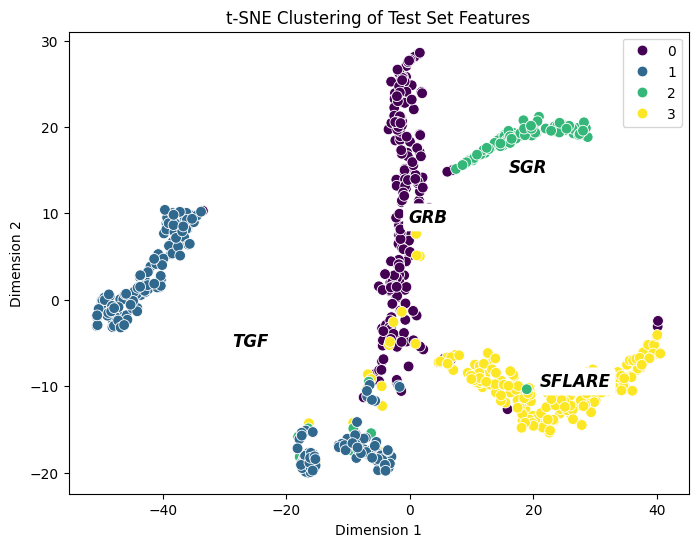

Figure saved successfully to: C:\Users\arpan\OneDrive\Documents\GRB\Plots\tsne_midcl.pdf


'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\Plots\\tsne_midcl.pdf'

In [41]:
# tsne plots

# Extract features from the penultimate layer
intermediate_layer_model = models.Model(inputs=model.inputs, outputs=model.layers[-2].output)
features = intermediate_layer_model.predict(X_test)

# Reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)
y_true = np.argmax(Y_test, axis=1)

class_names = ['GRB', 'TGF', 'SGR', 'SFLARE']

# Plot the 2D features
fig = plt.figure(figsize=(8, 6))
sb.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=y_true, palette="viridis", s=60)

# Remove the legend to replace it with custom annotations
for i, class_name in enumerate(class_names):
    # Get the center of each class' points by calculating the mean of their positions
    cluster_center = features_2d[y_true == i].mean(axis=0)
    
    # Add a label near the center of each cluster with an arrow pointing to the cluster
    plt.annotate(class_name, 
                 xy=cluster_center, 
                 xytext=(cluster_center[0] + 0.3, cluster_center[1] + 0.3),  # Offset for the text label
                 arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle="->", lw=1.5),
                 fontsize=12, fontweight='bold', color='black', style='italic',
                 ha='left', va='center', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))
    
plt.title("t-SNE Clustering of Test Set Features")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

save_to_dir(fig , 'tsne_midcl') # change name for clarity


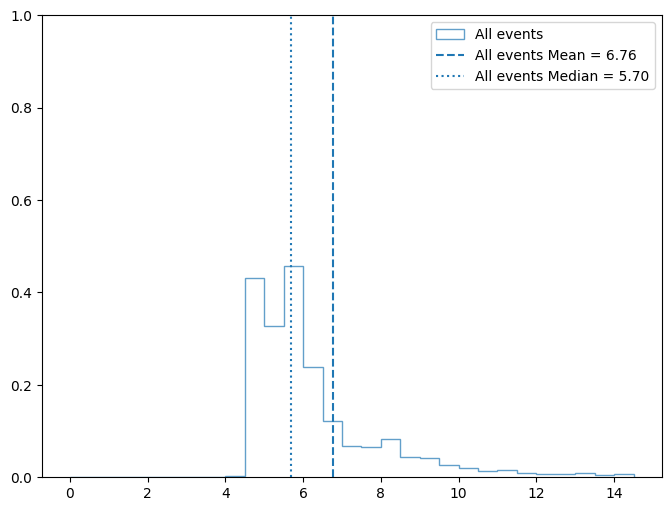

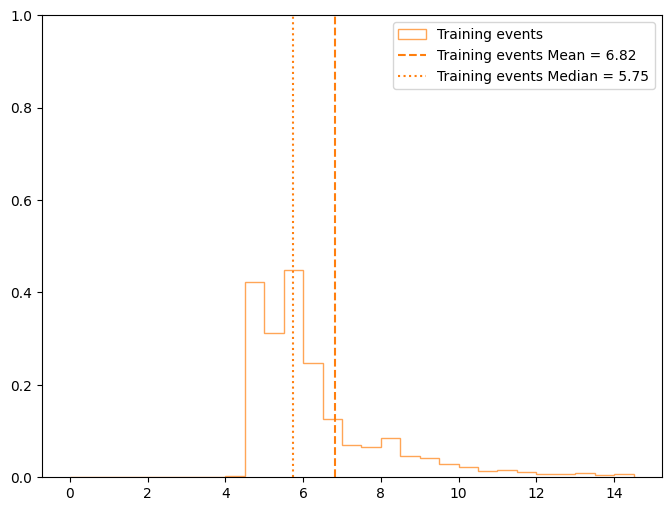

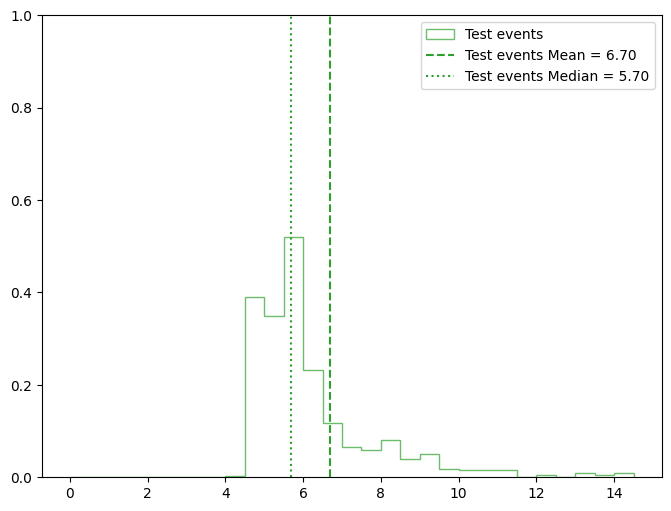

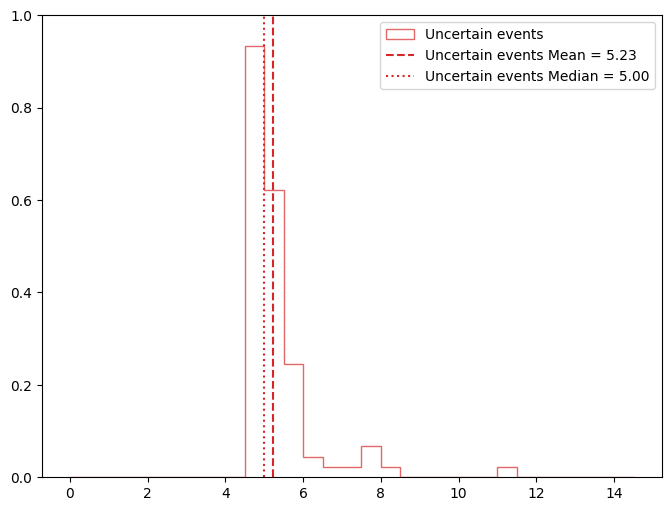

In [19]:
# significance distribution

# importing the events.csv file
df = pd.read_csv('events.csv')

# removing 0 values
df = df[df['TRIG_SIG'] != 0]

# bins
bin_size = 0.5
bins = np.arange(0, 15, bin_size)

def plot_sig(x, label, c = 0, bins = bins):
    fig = plt.figure(figsize=(8,6))
    x = np.array(x)
    plt.hist(x, bins=bins, rwidth = 0.9,histtype='step', alpha=0.7 , density= True, label=label, color=colors[c])
    plt.vlines(x.mean(), 0, 1, colors=colors[c], linestyles='dashed', label=  f'{label} Mean = {x.mean():.2f}')
    plt.vlines(np.median(x)  , 0, 1, colors=colors[c], linestyles='dotted', label=f'{label} Median = {np.median(x):.2f}')
    plt.ylim(0,1)
    plt.legend()
    plt.show()


# get all unique values in 'category'
categories = df['category'].unique()

# plotting all triggers
plot_sig(df['TRIG_SIG'], 'All events', 0 )

# plotting training triggers
plot_sig(df[df['category'] == 'train']['TRIG_SIG'], 'Training events', 1)

# plotting test trigger
plot_sig(df[df['category'] == 'test']['TRIG_SIG'], 'Test events', 2)

# plotting uncertain triggers
plot_sig(df[df['category'] == 'uncert']['TRIG_SIG'], 'Uncertain events', 3)




In [43]:
# confidence probability plots


In [44]:
# Lightcurves


In [45]:
# Bayesian analysis plots